# LSTM-BASED STOCK PREDICTION MODEL AND ANALYSIS

### LEI YUXIN
### CST1809212

In [1]:
import os
import numpy as np 
import pandas as pd

## Store the prediction details

In [2]:
# Basic stock information
import argparse
import secrets
from datetime import datetime

parser = argparse.ArgumentParser(description=("parsing arguments"))
parser.add_argument("-ticker", default="GOOG")      # The name of stock
# "AAPL" "GOOG" "META" "DIS" "MSFT"

parser.add_argument("-start_date", default="2014-01-01")
parser.add_argument("-validation_date", default="2018-07-01")
parser.add_argument("-end_date", default="2019-12-31")

# parser.add_argument("-start_date", default="2009-04-06")
# parser.add_argument("-validation_date", default="2017-04-04")
# parser.add_argument("-end_date", default="2020-04-05")

# parser.add_argument("-start_date", default="2012-01-01")
# parser.add_argument("-validation_date", default="2016-12-31")
# parser.add_argument("-end_date", default="2017-02-28")

parser.add_argument("-epochs", default="200")       # How many times the entire sample data will be "rotated" during training
parser.add_argument("-batch_size", default="32")    # The number of samples selected for one training session
parser.add_argument("-time_steps", default="3")     # How many moments are contained in each sample (step size)
parser.add_argument("-inputs_dim", default="6") 
args, unknown = parser.parse_known_args()

In [3]:
# Print information

STOCK_TICKER = args.ticker
STOCK_START_DATE = pd.to_datetime(args.start_date)
STOCK_VALIDATION_DATE = pd.to_datetime(args.validation_date)
STOCK_END_DATE = pd.to_datetime(args.end_date)
EPOCHS = int(args.epochs)
BATCH_SIZE = int(args.batch_size)
TIME_STEPS = int(args.time_steps)
INPUTS_DIM = int(args.inputs_dim)
TODAY_RUN = datetime.today().strftime("%Y%m%d")
TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)
print('Ticker: ' + STOCK_TICKER)
print('Start Date: ' + STOCK_START_DATE.strftime("%Y-%m-%d"))
print('Validation Start Date: ' + STOCK_VALIDATION_DATE.strftime("%Y-%m-%d"))
print('End Start Date: ' + STOCK_END_DATE.strftime("%Y-%m-%d"))
print('Test Run Folder: ' + TOKEN)

# create project run folder
PROJECT_FOLDER = os.path.join(os.getcwd(), TOKEN)
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)

Ticker: GOOG
Start Date: 2014-01-01
Validation Start Date: 2018-07-01
End Start Date: 2019-12-31
Test Run Folder: GOOG_20221210_8d8f89a39fc22c81573b61ce02d3b4a3


Save stock data details and forecast details in the form of classes.

In [4]:
# StockPrediction class is used to store the prediction details fo data set.
# The details of the dataset's predictions are recorded in the form of class.

class StockPrediction:
    def __init__(self, ticker, start_date, validation_date, end_date, project_folder):
        self._ticker = ticker
        self._start_date = start_date
        self._validation_date = validation_date
        self._end_date = end_date
        self._project_folder = project_folder

    def get_ticker(self):
        return self._ticker

    def set_ticker(self, value):
        self._ticker = value

    def get_start_date(self):
        return self._start_date

    def set_start_date(self, value):
        self._start_date = value

    def get_validation_date(self):
        return self._validation_date

    def set_validation_date(self, value):
        self._validation_date = value
        
    def get_end_date(self):
        return self._end_date

    def set_end_date(self, value):
        self._end_date = value
        
    def get_project_folder(self):
        return self._project_folder

    def set_project_folder(self, value):
        self._project_folder = value

In [5]:
# StockData class is used to store the stock details
# Details of stock data are recorded in the form of classes

from sklearn.preprocessing import MinMaxScaler

class StockData:
    def __init__(self, stock):
        self._stock = stock  # download stock data
        self._sec = yf.Ticker(self._stock.get_ticker())
        self._min_max = MinMaxScaler(feature_range=(0, 1))

    def data_verification(self, train):
        print('mean:', train.mean(axis=0))
        print('max', train.max())
        print('min', train.min())
        print('Std dev:', train.std(axis=0))

    def get_stock_short_name(self):
#         return self._sec.info['shortName']
        return STOCK_TICKER

    def get_stock_currency(self):
#         return self._sec.info['currency']
        return 'USD'
    
    def get_min_max(self):
        return self._min_max
    
    def __date_range(self, start_date, end_date):
        for n in range(int((end_date - start_date).days)):
            yield start_date + timedelta(n)

    def negative_positive_random(self):
        return 1 if random.random() < 0.5 else -1

    def pseudo_random(self):
        return random.uniform(0.01, 0.03)

In [6]:
# A class for drawing plot

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

class Plotter:
    def __init__(self, blocking, stock_data, stock_ticker,project_folder):
        self.blocking = blocking
        self.stock_data = stock_data
        self.stock_ticker = stock_ticker
        self.project_folder = project_folder
        self.short_name = stock_data.get_stock_short_name()
        self.currency = stock_data.get_stock_currency()

    def plot_histogram_data_split(self,training_data, test_data, validation_date):
        print("plotting Data and Histogram")
        plt.figure(figsize=(14, 5))
        plt.plot(training_data.Close, color='green')
        plt.plot(test_data.Close, color='red')
        plt.ylabel('Price [ ' + self.currency + ' ]')
        plt.xlabel("Date")
        plt.legend(["Training Data", "Validation Data >= " + validation_date.strftime("%Y-%m-%d")])
        plt.title(self.short_name)
        plt.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_price_line.png'))
        plt.show(block=self.blocking)
        
    def plot_histogram_data_block(self,training_data):
        plt.figure(figsize=(5, 5))
        plt.hist(training_data)
        plt.grid()
        plt.title('Close')
        plt.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_price_block.png'))
        plt.show(block=self.blocking)


    def plot_loss(self, history):
        print("plotting loss")
        plt.figure(figsize=(5, 5))
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss/Validation Loss')
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(self.project_folder, 'loss.png'))
        plt.pause(0.001)
        plt.show()

    def plot_mse(self, history):
        print("plotting MSE")
        plt.figure(figsize=(5, 5))
        plt.plot(history.history['MSE'], label='MSE')
        plt.plot(history.history['val_MSE'], label='val_MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title('MSE/Validation MSE')
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(self.project_folder, 'MSE.png'))
        plt.pause(0.001)
        plt.show()
        
    def project_plot_diff(self, diff):
        print("Plotting diff")
        plt.figure(figsize=(14, 5))
        plt.plot(diff)
        plt.xlabel('Time')
        plt.ylabel('Price [' + self.currency + ']')
        plt.title(self.short_name + 'Diff')
        plt.grid()
        plt.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_diff.png'))
        plt.pause(0.001)
        plt.show(block=self.blocking)

    def project_plot_predictions(self, price_predicted, test_data):
        print("plotting predictions")
        plt.figure(figsize=(14, 5))
        plt.plot(price_predicted[self.stock_ticker + '_predicted'], color='red', label='Predicted [' + self.short_name + '] price')
        plt.plot(test_data.Close, color='green', label='Actual [' + self.short_name + '] price')
        plt.xlabel('Time')
        plt.ylabel('Price [' + self.currency + ']')
        plt.legend()
        plt.title(self.short_name + ' Prediction')
        plt.savefig(os.path.join(self.project_folder, self.short_name.strip().replace('.', '') + '_prediction.png'))
        plt.pause(0.001)
        plt.show(block=self.blocking)

# 1. Data Collection and Description

In [7]:
# Download the dataset with Yahoo Finance
import yfinance as yf

stock_prediction = StockPrediction(STOCK_TICKER, STOCK_START_DATE, STOCK_VALIDATION_DATE, STOCK_END_DATE, PROJECT_FOLDER)
stock_data = StockData(stock_prediction)

data = yf.download([stock_prediction.get_ticker()], start=stock_prediction.get_start_date(), end=stock_prediction.get_end_date())
data.to_csv(os.path.join(stock_prediction.get_project_folder(), 'downloaded_data_'+ STOCK_TICKER +'.csv'))

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,27.702166,27.920347,27.553225,27.913124,27.913124,54519590
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
...,...,...,...,...,...,...
2019-12-23,67.793503,67.989998,67.325500,67.442001,67.442001,17662000
2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000
2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000


In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,42.698403,43.053487,42.327813,42.702560,42.702560,3.676661e+07
std,12.414488,12.535222,12.329368,12.438596,12.438596,2.139467e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,1.584340e+05
25%,30.062692,30.192083,29.764977,29.963875,29.963875,2.467900e+07
50%,39.890999,40.162251,39.665251,39.851000,39.851000,3.066000e+07
75%,54.164376,54.708437,53.655399,54.134501,54.134501,4.121870e+07
max,68.167503,68.250000,67.633499,68.058502,68.058502,2.234866e+08


In [9]:
corr = np.corrcoef(np.array(data), rowvar=False)
corr

array([[ 1.        ,  0.99963253,  0.99949488,  0.99910017,  0.99910017,
        -0.28384323],
       [ 0.99963253,  1.        ,  0.99942267,  0.99954202,  0.99954202,
        -0.2787666 ],
       [ 0.99949488,  0.99942267,  1.        ,  0.99964728,  0.99964728,
        -0.29424586],
       [ 0.99910017,  0.99954202,  0.99964728,  1.        ,  1.        ,
        -0.28853595],
       [ 0.99910017,  0.99954202,  0.99964728,  1.        ,  1.        ,
        -0.28853595],
       [-0.28384323, -0.2787666 , -0.29424586, -0.28853595, -0.28853595,
         1.        ]])

# 2. Data Set Splitting

In [10]:
data = data.reset_index()

training_data = data[data['Date'] < stock_prediction.get_validation_date()].copy()
test_data = data[data['Date'] >= stock_prediction.get_validation_date()].copy()

training_data = training_data.set_index('Date')
test_data = test_data.set_index('Date')

print(test_data.head(3))
print(test_data.shape)
print(training_data.head(3))
print(training_data.shape)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-07-02  54.950001  56.400002  54.689999  56.373001  56.373001  24346000
2018-07-03  56.791000  56.791000  55.000999  55.144501  55.144501  13580000
2018-07-05  55.526501  56.375000  55.424000  56.213501  56.213501  21334000
(377, 6)
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2013-12-31  27.702166  27.920347  27.553225  27.913124  27.913124  54519590
2014-01-02  27.782366  27.839401  27.603037  27.724083  27.724083  73129082
2014-01-03  27.770908  27.818977  27.520098  27.521841  27.521841  66917888
(1133, 6)


In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1133 entries, 2013-12-31 to 2018-06-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1133 non-null   float64
 1   High       1133 non-null   float64
 2   Low        1133 non-null   float64
 3   Close      1133 non-null   float64
 4   Adj Close  1133 non-null   float64
 5   Volume     1133 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 62.0 KB


plotting Data and Histogram


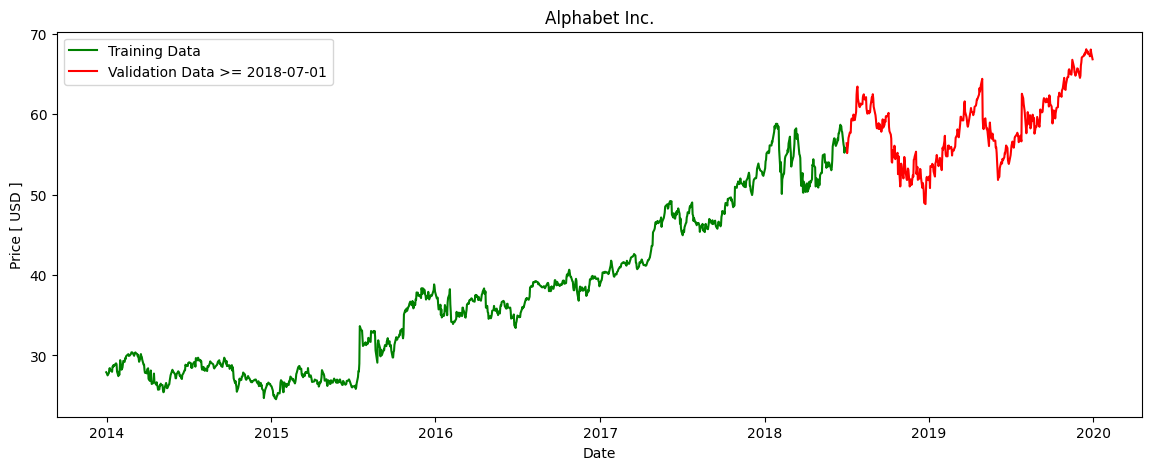

In [12]:
# The image shows the y values of the test and training sets
# y values is the close prices of stock

plotter = Plotter(True,stock_data,STOCK_TICKER,PROJECT_FOLDER)
plotter.plot_histogram_data_split(training_data, test_data, stock_prediction.get_validation_date())

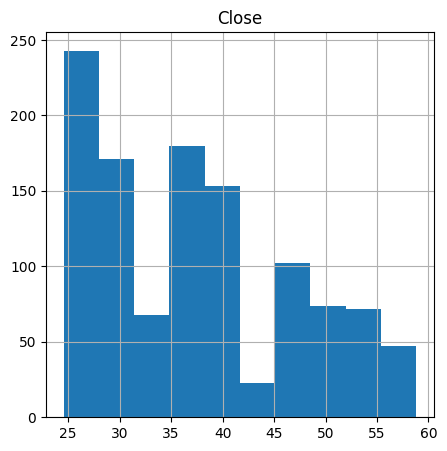

In [13]:
plotter.plot_histogram_data_block(training_data.Close)

# 3.Data Pre-processing

To achieve data normalization.

In [14]:
# The data set was normalized with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# The training data set is normalized
train_scaled = scaler.fit_transform(training_data)
stock_data.data_verification(train_scaled)

mean: [0.37385575 0.37597931 0.37382674 0.37648256 0.37648256 0.17361305]
max 1.0
min 0.0
Std dev: [0.27624278 0.27549326 0.27381313 0.27661037 0.27661037 0.10323572]


In [15]:
# The testing data set is normalized
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - TIME_STEPS:]
test_scaled = scaler.fit_transform(inputs)

# 4. Adding Time Step

In [16]:
# Training Data Transformation
x_train = []
y_train = []

for i in range(TIME_STEPS, train_scaled.shape[0]):
    x_train.append(train_scaled[i - TIME_STEPS:i])
    y_train.append(train_scaled[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], INPUTS_DIM))

In [17]:
# Testing Data Transformation
x_test = []
y_test = []

for i in range(TIME_STEPS, test_scaled.shape[0]):
    x_test.append(test_scaled[i - TIME_STEPS:i])
    y_test.append(test_scaled[i, 3])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], INPUTS_DIM))

In [18]:
print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(1130, 3, 6) (1130,) (377, 3, 6) (377,)


# 5. Building the LSTM Model

In [19]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, LSTM
from tensorflow.python.keras.optimizers import *


class LongShortTermMemory:
    def __init__(self, stock):
        self.stock = stock

    def get_defined_metrics(self):
        defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
        return defined_metrics

    def get_callback(self):
        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.001, patience=50, mode='min', verbose=1)
        return callback

    def create_model(self, x_train):
        model = Sequential()
        # 1st layer with Dropout regularisation
        # * units = add 100 neurons is the dimensionality of the output space
        # * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
        # * input_shape => Shape of the training dataset
        model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        # 20% of the layers will be dropped
        model.add(Dropout(0.20))
        # 2nd LSTM layer
        # * units = add 50 neurons is the dimensionality of the output space
        # * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
        model.add(LSTM(units=50, return_sequences=True))
        # 10% of the layers will be dropped
        model.add(Dropout(0.1))
        # 3rd LSTM layer
        # * units = add 50 neurons is the dimensionality of the output space
        # * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
        model.add(LSTM(units=100, return_sequences=True))
        # 50% of the layers will be dropped
        model.add(Dropout(0.50))
        # 4th LSTM layer
        # * units = add 50 neurons is the dimensionality of the output space
        model.add(LSTM(units=30))
        # Dense layer that specifies an output of one unit
        model.add(Dense(units=1))
        model.summary()
        #tf.keras.utils.plot_model(model, to_file=os.path.join(self.project_folder, 'model_lstm.png'), 
        #                          show_shapes=True, show_layer_names=True)
        return model
    

# 5. Traning model

In [20]:
lstm = LongShortTermMemory(stock_prediction)
model = lstm.create_model(x_train)

# compile() method: Specify losses, metrics, and optimizers
model.compile(optimizer = adam_v2.Adam(learning_rate=0.005), 
              loss='mean_squared_error', metrics=lstm.get_defined_metrics())

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), callbacks=[lstm.get_callback()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            42800     
_________________________________________________________________
dropout (Dropout)            (None, 3, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 100)            60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                1

In [21]:
# Saving weights of model

print("Saving weights")
model.save(os.path.join(stock_prediction.get_project_folder(), 'model_weights.h5'))

Saving weights


plotting loss


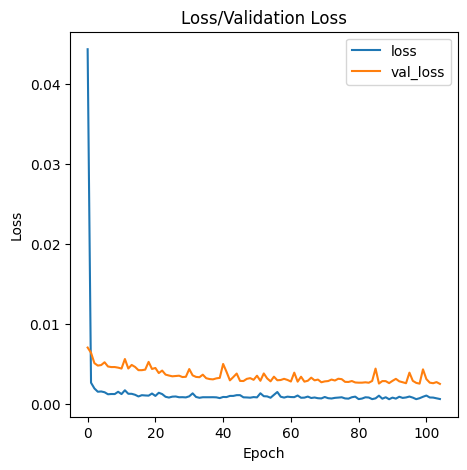

plotting MSE


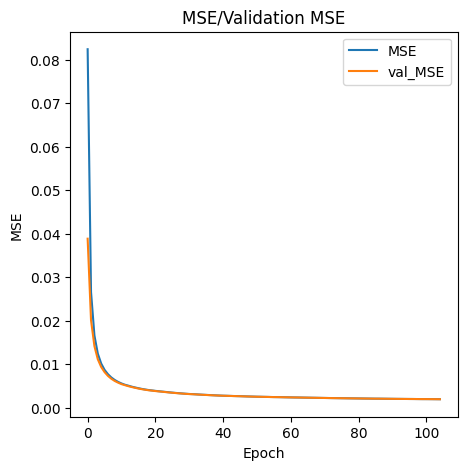

In [22]:
# show the loss and mse
plotter.plot_loss(history)
plotter.plot_mse(history)

In [23]:
print("Display the content of the model")
baseline_results = model.evaluate(x_test, y_test, verbose=2)  #verbose =2：Output one row of records for each epoch
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

Display the content of the model
12/12 - 0s - loss: 0.0025 - MSE: 0.0019
loss :  0.0025487602688372135
MSE :  0.0019464042270556092


# 6. Prediction

In [24]:
# Use the established and trained model to predict
test_predictions_baseline = model.predict(x_test)

scaler.fit_transform(pd.DataFrame(test_data['Close'].values))
test_predictions_baseline = scaler.inverse_transform(test_predictions_baseline)
test_predictions_baseline = pd.DataFrame(test_predictions_baseline)
test_predictions_baseline.to_csv(os.path.join(stock_prediction.get_project_folder(), 'predictions.csv'))

In [25]:
# The predicted data is reversely normalized
# Obtain the predicted closing price of the stock

y_test = scaler.inverse_transform([y_test])
y_test.reshape(-1,1)
y_test = pd.DataFrame(y_test)
y_test = pd.DataFrame(y_test.values.T,columns = y_test.index,index = y_test.columns) 

Plotting prediction results
plotting predictions


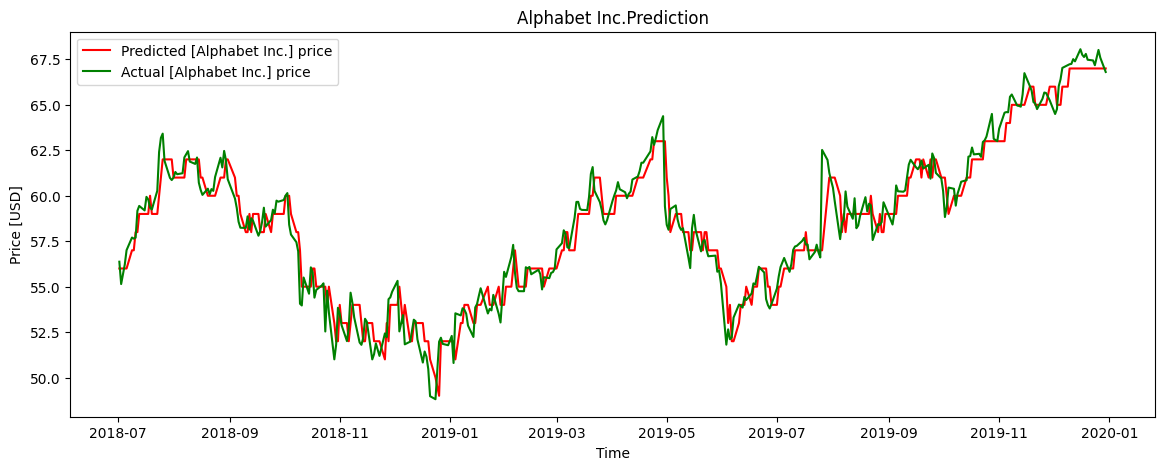

In [26]:
print("Plotting prediction results")

test_predictions_baseline.rename(columns={0: STOCK_TICKER + '_predicted'}, inplace=True)
test_predictions_baseline = test_predictions_baseline.round(decimals=0)
test_predictions_baseline.index = test_data.index
plotter.project_plot_predictions(test_predictions_baseline, test_data)

Plotting diff


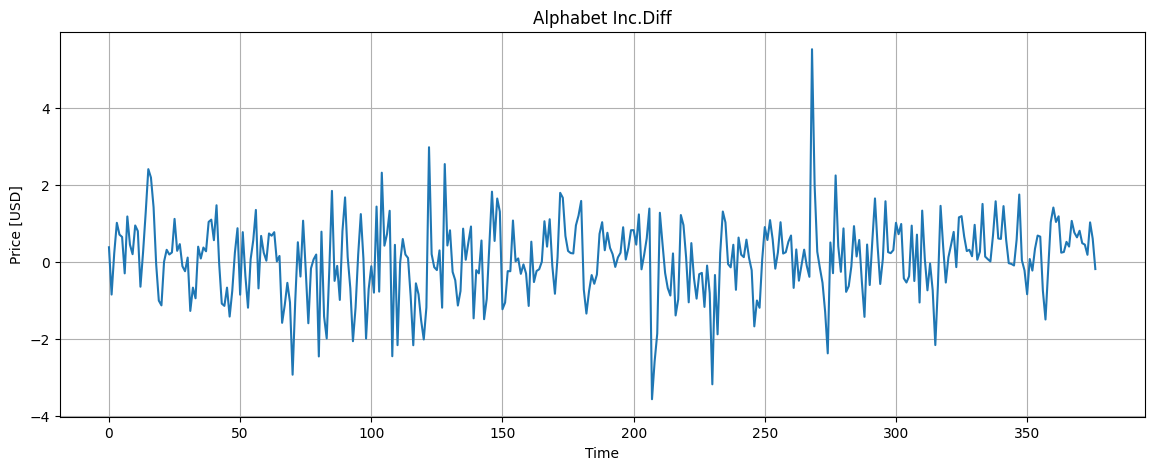

In [27]:
diff = np.array(y_test) - np.array(test_predictions_baseline)
plotter.project_plot_diff(diff)

# 7. Evaluation

In [28]:
import math, time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test,test_predictions_baseline)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(y_test, test_predictions_baseline)
mbe = np.mean(np.abs(np.array(y_test) - np.array(test_predictions_baseline)))
r2 = r2_score(y_test,test_predictions_baseline)
accuracy = 1 - np.sqrt(np.mean(np.square(np.array(test_predictions_baseline) - np.array(y_test))/ np.array(y_test)))

print("Evaluate " + STOCK_TICKER + " Prediction\n")
print('mse = ',mse )
print('rmse = ',rmse )
print('mape = ',mape )
print('mbe = ',mbe )
print('r2 = ',r2 )
print('accuracy = %.2f%% '%(accuracy * 100))

Evaluate GOOG Prediction

mse =  1.0036782128741397
rmse =  1.0018374183839112
mape =  0.013031079894248633
mbe =  0.7523897712363489
r2 =  0.942489041533572
accuracy = 86.77% 
